In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt  
from sklearn.model_selection import cross_val_score
from datetime import datetime, date
import calendar

In [2]:
confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


# Data preparation

Na preparação dos dados decidimos trabalhar com as três variáveis obtidas dos datasets anteriores( 'Total_Cases', 'Total_Recovered' e 'Total_Deaths') para além disso decidimos criar algumas variáveis: 

- Days-Gone - Número de dias desde o inicio da pandemia.
- Daily_Cases - Número de casos diários no país ou no mundo.
- Daily_Deaths - Número de mortes diárias no país ou no mundo.
- WeekDay - Dia da semana 

'Daily_Cases' e 'Daily_Deaths' foram criados para testar se a previsão era melhor com os casos totais ou com os casos diários.

A variável 'WeekDay' foi criada com o intuito de separar os dias da semana dos fins de semana visto que o valor de casos é inferior durante o fim de semana devido a stiuações diversas entre os vários países. Gráfico onde é comparado os casos nos diferentes dias da semana é realizado no final do notebook.


In [3]:
class Data():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        if(country == "World Wide"):
            self.PreparaDataGlobal()
        else:
            self.PreparaData()

    def PreparaData(self):
        confirmedPortugal = self.confirmed[ self.confirmed['Country/Region'] != self.country].index
        self.confirmed.drop(confirmedPortugal , inplace=True)
        deathsPortugal = self.deaths[ self.deaths['Country/Region'] != self.country].index
        self.deaths.drop(deathsPortugal , inplace=True)
        recoveredPortugal = self.recovered[ self.recovered['Country/Region'] != self.country].index
        self.recovered.drop(recoveredPortugal , inplace=True)
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        daily_deaths=[]
        daily_cases=[]
        day_of_week=[]
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            day_of_week.append(current_date.weekday())
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
            daily_cases.append(self.confirmed[cols].sum()-sum(daily_cases))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
            daily_deaths.append(self.deaths[cols].sum()-sum(daily_deaths))
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Daily_Cases'] = daily_cases
        self.new_dataset['WeekDay'] = day_of_week
        self.new_dataset['Daily_Deaths'] = daily_deaths
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)
    def PreparaDataGlobal(self):
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)

# Portugal

Decidimos utilizar Portugal como exemplo para as nossas previsões e para além disso só utilizados valores com 'Total_Cases' no país superior a zero, ou seja, desde que começou a pandemia no país.

In [4]:
dados = Data('Portugal')

In [5]:
dados.new_dataset=dados.new_dataset[dados.new_dataset['Total_Cases']>0]
dados.new_dataset=dados.new_dataset.reset_index()
dados.new_dataset=dados.new_dataset.drop(columns='index')
dados.new_dataset

,Total_Cases,Daily_Cases,WeekDay,Daily_Deaths,Total_Recovered,Total_Deaths,Days_Gone
0,2,2,0,0,0,0,62
1,2,0,1,0,0,0,63
2,5,3,2,0,0,0,64
3,8,3,3,0,0,0,65
4,13,5,4,0,0,0,66
...,...,...,...,...,...,...,...
108,38089,417,3,1,24010,1524,170
109,38464,375,4,3,24477,1527,171
110,38841,377,5,1,24906,1528,172
111,39133,292,6,2,25376,1530,173


# Linear Regression
Decidimos utilizar a Linear Regression para compararmos os resultado com as RNN e verificar qual das abordagens é que obtinhamos melhores resultados.

Na preparação dos dados estamos a utilizar o 'Days_Gone' para prever o 'Total_Cases', decidimos deixar o 'Total_Cases' pois, estávamos a obter melhores resultados em detrimento de 'Daily_Cases'. (A experiência pode ser verificada alterando o atributo de teste).

Como o dataset é pequeno decidimos utilizar apenas 10% do dataset para treino.

Na fase de treino foi implementado três métodos:
- Ridge
- Lasso
- Regressor

O método que se obteve melhores resultados foi o Lasso mas todos os métodos têm resultados parecidos. Para além disso também fizemos algumas experiência com o 'alpha' e 'max_iter' nos métodos 'Ridge' e 'Lasso'.

Outra experiência realizada foi a normalização dos dados e verificar a diferença de resultados.



In [6]:
class Linear_Regression():
    def __init__(self,data):
        self.dataset = data
        self.dataset = np.asarray(self.dataset)
        #self.NormalizeData()
        self.PrepareData()
        self.Fit()
        
    def PrepareData(self):
        self.x_train, self.x_test,self.y_train, self.y_test = train_test_split(self.dataset[:,-1],self.dataset[:,0], test_size=0.1)
    def Fit(self):
        
        #self.ridge = linear_model.Ridge(alpha=.001,max_iter=1000)
        #self.ridge.fit(np.reshape(self.x_train,(-1,1)), self.y_train)
        
        self.lasso = linear_model.Lasso(alpha=.01,max_iter=20000)
        self.lasso.fit(np.reshape(self.x_train,(-1,1)), self.y_train)
        
        
        #self.regressor = LinearRegression()  
        #self.regressor.fit(np.reshape(self.x_train,(-1,1)),self.y_train) #training the algorithm
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.dataset = self.scaler.fit_transform(self.dataset)
        #print(self.normalized)
    def ComparePredictions(self):
        self.y_pred = self.lasso.predict(np.reshape(self.x_test,(-1,1)))
        count = 0
        test = np.asarray(self.y_test)
        for i in self.y_pred:
            if i<0:
                i=0
            print('Predicted:' + str(int(i))+ '===== Real:' +str(test[count]) )
            count +=1
            
        print('Mean Absolute Error:', metrics.mean_absolute_error(self.y_test, self.y_pred))
        #print('Mean Squared Error:', metrics.mean_squared_error(self.y_test, y_pred))



In [7]:
Model = Linear_Regression(dados.new_dataset)

### Resultado obtido com o método Lasso

In [8]:
Model.lasso.score(np.reshape(Model.x_train,(-1,1)),np.reshape(Model.y_train,(-1,1)))

0.9664221989385352

### Comparação de resultados entre o real e a regressão linear

Podemos verificar casos onde a previsão foi realista e outros casos em que a previsão foi irrealista. Estes resultados podem ser melhorados com os seguintes fatores:

- Maior dataset
- Melhor otimização de hiperparâmetros

Podemos concluir que os resultados foram piores em relação as RNN(LSTM's e GRU's).


In [9]:
Model.ComparePredictions()

Predicted:21570===== Real:25351
Predicted:24732===== Real:27406
Predicted:32638===== Real:31946
Predicted:13664===== Real:15987
Predicted:8525===== Real:5962
Predicted:6153===== Real:2060
Predicted:20384===== Real:24322
Predicted:3386===== Real:331
Predicted:31057===== Real:30788
Predicted:18012===== Real:21982
Predicted:0===== Real:2
Predicted:41730===== Real:39133
Mean Absolute Error: 2642.5573430710806


### Gráfico onde é comparado os valores reais com a previsão da regressão linear

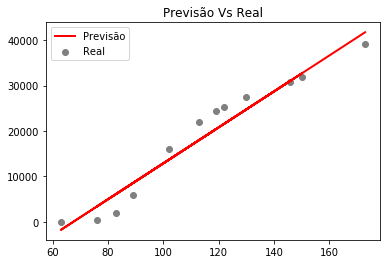

In [10]:
plt.scatter(Model.x_test, Model.y_test,  color='gray',label='Real')
plt.plot(Model.x_test, Model.y_pred, color='red', linewidth=2,label='Previsão')
plt.title('Previsão Vs Real')
plt.legend()
plt.show()

### Week day

Gráfico onde é comparada a média de casos diários nos diferentes dias da semana, de realçar que os valores equivalem ao dia anterior por exemplo, os valores de sabado equivalem à média de casos diários na sexta feira.

Pode-se verificar que a média de casos diários é menor ao domingo e segunda(que equivale a sábado e domingo).

Estes resultados são mais acentuados em outros países como por exemplo o 'Brazil' e este facto deve-se a muitos dos laboratórios encontrarem-se encerrados durante o fim de semana.

Depois de constatar este facto decidimos utilizar o 'WeekDay' nas previsões.

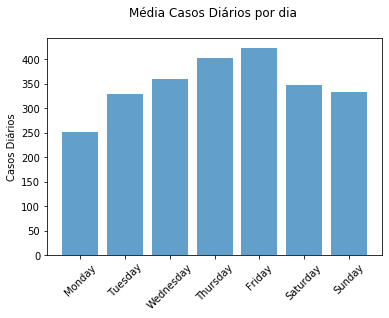

In [14]:
df_totalCases= dados.new_dataset.groupby('WeekDay').mean()
df_totalCases=df_totalCases['Daily_Cases']
dia = []
for i in range(0,7):
    dia = dia + [str(calendar.day_name[i])]
df_totalCases.index=dia
df_totalCases
def Grafico_SpeedDiff_por_dia(df):
    fig, ax = plt.subplots()
    plt.bar(df.index, df, align='center', alpha=0.7)
    
    plt.title('Média Casos Diários por dia \n')
    plt.ylabel("Casos Diários")
    plt.xticks(rotation=45)
    plt.show()
    #fig.savefig("Imagens/Speed_Diff_Dia.png")

Grafico_SpeedDiff_por_dia(df_totalCases)

In [12]:
df_totalCases= dados.new_dataset.groupby('WeekDay').mean()
df_totalCases=df_totalCases['Daily_Cases']
df_totalCases

WeekDay
0    252.352941
1    329.500000
2    362.375000
3    405.125000
4    424.562500
5    338.187500
6    334.125000
Name: Daily_Cases, dtype: float64

## Método para corrigir os casos negativos

In [13]:
def CorrigirCasosNegativos(fator,df):
    for index,row in df.iterrows():
        if(row['Daily_Cases']<0):
            df.loc[index-fator:index,'Daily_Cases']=df.loc[index-fator:index,'Daily_Cases'].sub(int(abs(row['Daily_Cases'])/fator))
            df.loc[index-fator:index,'Total_Cases']=df.loc[index-fator:index,'Total_Cases'].sub(int(abs(row['Daily_Cases'])/fator))

            row['Daily_Cases']=int(abs(row['Daily_Cases'])/fator)
# Número de dias que se corrige
fator=10
CorrigirCasosNegativos(fator,dados.new_dataset)

161
61
    Total_Cases  Daily_Cases  WeekDay  Daily_Deaths  Total_Recovered  \
51        21982          603        2            23             1143   
52        22353          371        3            35             1201   
53        22797          444        4            34             1228   
54        23392          595        5            26             1277   
55        23864          472        6            23             1329   
56        24027          163        0            25             1357   
57        24322          295        1            20             1389   
58        24505          183        2            25             1470   
59        25045          540        3            16             1519   
60        25351          306        4            18             1647   

    Total_Deaths  Days_Gone  
51           785        113  
52           820        114  
53           854        115  
54           880        116  
55           903        117  
56           928    